# Deepweeds - MobileNetv3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

tf.__version__

2025-07-06 08:08:30.544094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-06 08:08:30.544212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-06 08:08:30.682950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

# Configurations

In [2]:
INFERENCE_DEVICE = 'GPU:0' if len(tf.config.list_physical_devices('GPU')) else 'CPU:0'

################################
###### Configurations #########
##############################
seed = 999
SEED = seed
USE_DETERMINISTIC = True
K_FOLD_INDEX = 4
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME=f"MobileNetV3Small_KF{K_FOLD_INDEX+1}.keras"
IMG_SIZE=(224,224,3)

## Training Configurations
TRAIN_BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 16 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-7 ## Minimum Learning Rate for ReduceLROnPlateau Callback
##
USE_WARMUP = False
WARMUP_EPOCHS = 5
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCHS
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.3

##### Base Model Freezing Part
INIT_LR2 = 2e-6 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-4 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau

#### -- Optimizer
USE_ADAMW = '2.15' in tf.__version__
#########################################
isKaggle = 'kaggle' in os.getcwd()

if isKaggle:
    DATASET_PATH = "/kaggle/input/deepweeds"
    IMAGE_DATASET_PATH = "/kaggle/input/deepweeds/images" ## For Kaggle
    DATASET_OUTPUT_PATH = "/kaggle/working/deepweeds_9c" ## For Kaggle
else:
    try:
        DATASET_PATH = reganmaharjan_deepweeds_path
        DATASET_OUTPUT_PATH = '/content/dataset_9c' ## For GoogleColab
        IMAGE_DATASET_PATH = reganmaharjan_deepweeds_path + '/images' ## For GoogleColab
    except:
        DATASET_PATH = ''
        IMAGE_DATASET_PATH = '' ## Assign The Image Path
        DATASET_OUTPUT_PATH = '' ## Assign The path where the Images are to ogranized for Data Generator from Directory


isTPU = False
fixDatasetBatch = False ## if True: duplicates files randomly such that each batch contains same no.of files - Required when isTPU=True.

In [3]:
print("Tensorflow version " + tf.__version__)
if tf.config.list_logical_devices('TPU'):
    if isKaggle:
        # On TPU VMs use this line instead:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  ## if kaggle
    else:        
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver() ## if colab

    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    #---------
    strategy = tf.distribute.TPUStrategy(resolver)
    print('TPU available')
    isTPU = True
else: ### If GPU or CPU
    if tf.config.list_logical_devices('GPU'): 
        print('GPU available')
    else:
        print("Only CPU available")
       
    # For testing without a TPU use this line instead: 
    # strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    strategy = tf.distribute.MirroredStrategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)
if isTPU:
    USE_ADAMW = False
    LR_REDUCTION_PATIENCE = 5
    ES_PATIENCE = 27
    print("Use ADAM with TPU")

Tensorflow version 2.15.0
GPU available
REPLICAS:  1


In [4]:
def seedEverything(seed=42, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    tf.keras.utils.set_random_seed(seed)
    
    if deterministic:
        tf.config.experimental.enable_op_determinism()
        
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED, USE_DETERMINISTIC)
tf.config.set_soft_device_placement(True)

In [5]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [6]:
try:
    data_info = pd.read_csv(f"{DATASET_PATH}/labels.csv") ## For Kaggle
except:
    data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [7]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [8]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [9]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 5 out of 5 folds
-------------------------------------------------



In [11]:
## Using Folds Used in The DeepWeeds Paper
try:
    train_data = pd.read_csv(f'{DATASET_PATH}/train_subset{K_FOLD_INDEX}.csv')
    valid_data = pd.read_csv(f'{DATASET_PATH}/val_subset{K_FOLD_INDEX}.csv')
    test_data = pd.read_csv(f'{DATASET_PATH}/test_subset{K_FOLD_INDEX}.csv')

except:
    train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
    valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
    test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab

train_data.rename(columns={"Label":"label"}, inplace=True)
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  606  645  610  5464 	Total: (10508, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  205  213  202  215  203  1821 	Total: (3503, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  204  212  201  214  203  1821 	Total: (3498, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0, oversampling_labels=[]):
    indices=[]
    if fixDatasetBatch or isTPU:
        batch = TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync
        size = data_info.shape[0]
        remainder = size % batch
        residue = batch - remainder
        rng = np.arange(size)
        np.random.shuffle(rng)
        indices = rng[:residue]
        
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)
            elif index in indices:
                sample_filename = os.path.join(target_path, f"last_batch_fix_{index}-"+filename)
                shutil.copy(source, sample_filename)
                
            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import math

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.0 if math.isnan(v) else v for v in history['accuracy']]
    val_acc = [0.0 if math.isnan(v) else v for v in history['val_accuracy']]
    loss = [0.0 if math.isnan(v) else v for v in history['loss']]
    val_loss = [0.0 if math.isnan(v) else v for v in history['val_loss']]
    
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [14]:
if oversampling:
    print("Oversampling training set",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

input_dir = IMAGE_DATASET_PATH
base_dir = DATASET_OUTPUT_PATH

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

with strategy.scope(): 
    if isTPU:  
        train_generator = train_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        validation_generator = validation_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        test_generator = test_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        
    train_generator = train_generator.prefetch(tf.data.AUTOTUNE)
    validation_generator = validation_generator.prefetch(tf.data.AUTOTUNE)
    test_generator = test_generator.prefetch(tf.data.AUTOTUNE)     

Found 10508 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.
Found 3498 files belonging to 9 classes.


# Sample Images

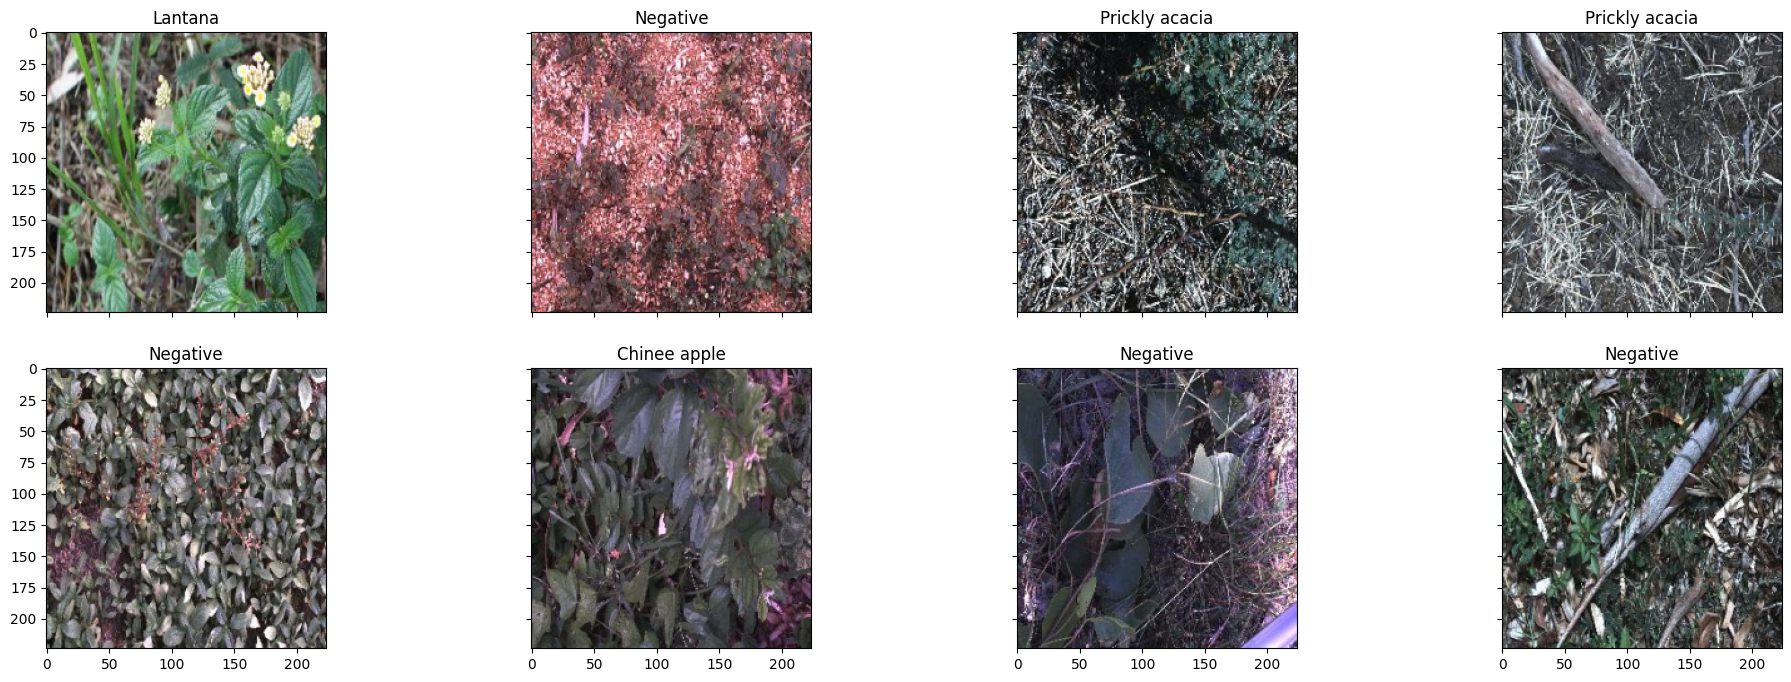

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    augs = [] if isTPU else [layers.RandomRotation(0.5, seed=seed, name='RR_Rot'), 
                            layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
                            layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),] ## can't run with TPU
    
    aug_model = keras.Sequential([
        layers.Input(IMG_SIZE),
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        *augs,
        layers.GaussianNoise(0.01, seed=SEED, name='RR_GNoise'),
        # layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')
    aug_model.summary()
    
    return aug_model


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('dropout' in mobilenet.layers[i].name):
            pi1 = i - 1 ## Not including dropout --
            break
    
    FCLayer = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-FCLayer")
    
    return base_model , FCLayer

def buildModel(IMG_SIZE, fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, FCLayer = MobilenetV3Base(IMG_SIZE)
    base_model.trainable = True
    FCLayer.trainable = True
    FCLayer.summary()
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.3, seed=SEED)(x) 
    
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = FCLayer(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
with strategy.scope():
    model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Model: "MobileNet-FCLayer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 1, 576)]          0         []                            
                                                                                                  
 Conv_2 (Conv2D)             (None, 1, 1, 1024)           590848    ['input_2[0][0]']             
                                                                                                  
 tf.__operators__.add_27 (T  (None, 1, 1, 1024)           0         ['Conv_2[1][0]']              
 FOpLambda)                                                                                       
                                                                                                  
 re_lu_32 (ReLU) 

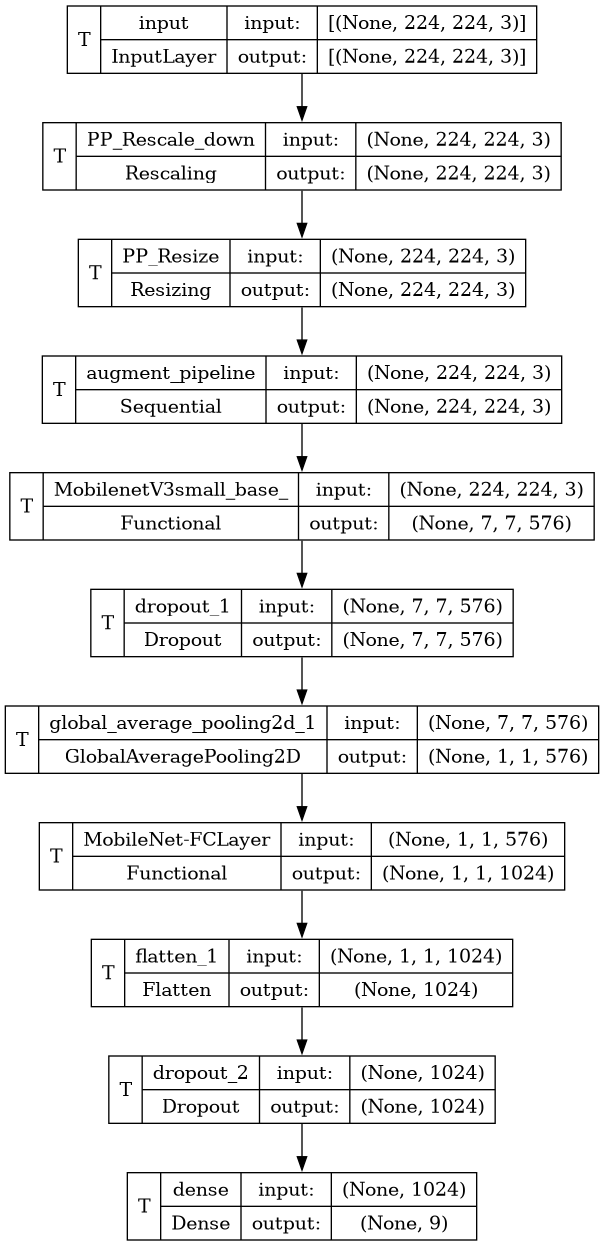

In [20]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import Adam, AdamW

checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor=ES_MONITOR)
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1, clipnorm=1.0) if not USE_ADAMW else AdamW(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

    def createWarmUpScheduler(epochs=5, inc_rate=0.5, init_lr=2e-6, final_lr=2e-5):
        def scheduler(e, lr):
            if e < epochs:
                new_lr =  lr + (lr * inc_rate)
                return new_lr if new_lr < final_lr else final_lr
            elif e == epochs:
                return final_lr
            else:
                return lr

        return scheduler
        
    warmup = keras.callbacks.LearningRateScheduler(createWarmUpScheduler(WARMUP_EPOCHS, WARMUP_INCREMENT_RATE, WARMUP_INIT_LR, INIT_LR1))

    callbacks = [checkpoint, early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])
    print(len(callbacks))

print(model.optimizer.get_config())

3
{'name': 'AdamW', 'weight_decay': 0.05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0002, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-07-06 08:11:43.492324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751789509.020763      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 55s 80ms/step - loss: 0.1885 - accuracy: 0.5954 - val_loss: 0.0997 - val_accuracy: 0.7451 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 23s 70ms/step - loss: 0.1121 - accuracy: 0.7089 - val_loss: 0.0702 - val_accuracy: 0.8096 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 23s 70ms/step - loss: 0.0873 - accuracy: 0.7653 - val_loss: 0.0585 - val_accuracy: 0.8367 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 23s 70ms/step - loss: 0.0755 - accuracy: 0.7943 - val_loss: 0.0521 - val_accuracy: 0.8544 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0700 - accuracy: 0.8105 - val_loss: 0.0452 - val_accuracy: 0.8670 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 23s 70ms/step - loss: 0.0609 - accuracy: 0.8273 - val_loss: 0.0442 - val_accuracy: 0.8741 - lr: 2.0000e-04
Epoch 7/300
329/329 [===================

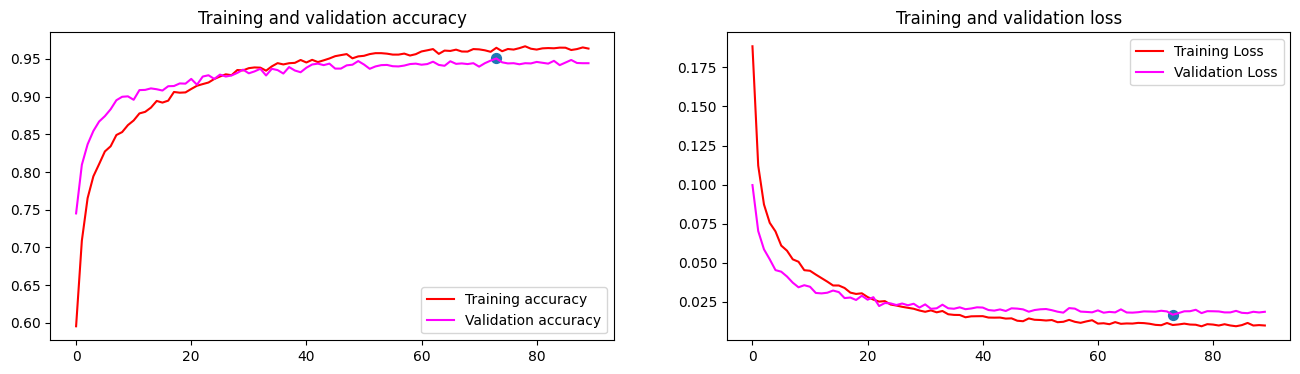

CPU times: user 1h 10min 18s, sys: 5min 24s, total: 1h 15min 43s
Wall time: 34min 50s


In [22]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0194 - accuracy: 0.9389
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.88426   0.84889   0.86621       225
       Lantana    0.95215   0.93427   0.94313       213
   Parkinsonia    0.95238   0.97087   0.96154       206
    Parthenium    0.97549   0.97073   0.97311       205
Prickly acacia    0.95610   0.92019   0.93780       213
   Rubber vine    0.94388   0.91584   0.92965       202
     Siam weed    0.92991   0.92558   0.92774       215
    Snake weed    0.90206   0.86207   0.88161       203
      Negative    0.95094   0.96870   0.95974      1821

      accuracy                        0.94433      3503
     macro avg    0.93857   0.92413   0.93117      3503
  weighted avg    0.94404   0.94433   0.94405      3503


                False Positive Rate  Accuracy
Chinee apple               0.007627  0.848889
Lantana                    0.003040  0.934272
Parkinsonia                0.003033  0.970874
Parthenium                 0.001516  0.970732
Prickly acacia    

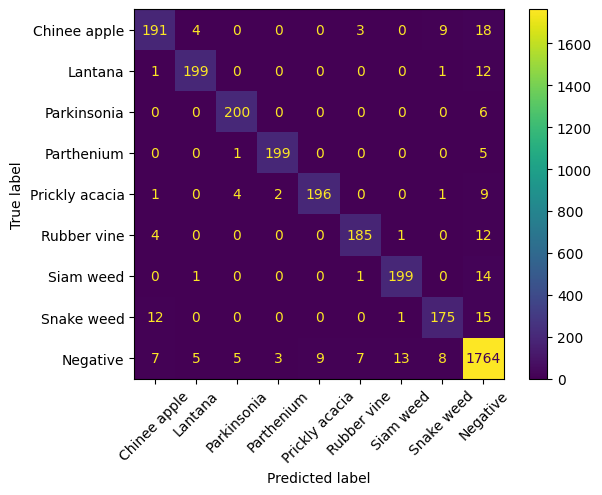


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 24ms/step - loss: 0.4935 - accuracy: 0.4828
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.12081   0.08000   0.09626       225
       Lantana    0.25000   0.11792   0.16026       212
   Parkinsonia    0.27586   0.03883   0.06809       206
    Parthenium    0.19298   0.05392   0.08429       204
Prickly acacia    0.20000   0.02830   0.04959       212
   Rubber vine    0.18519   0.07463   0.10638       201
     Siam weed    0.20690   0.08411   0.11960       214
    Snake weed    0.22727   0.07389   0.11152       203
      Negative    0.54260   0.86381   0.66653      1821

      accuracy                        0.48285      3498
     macro avg    0.24462   0.15727   0.16250      3498
  weighted avg    0.38150   0.48285   0.39472      3498


                False Positive Rate  Accuracy
Chinee apple               0.040024  0.080000
Lantana                    0.022824  0.117925
Parkinsonia                0.006379  0.038835
Parthenium                 0.013965  0.053922
Prickly acacia    

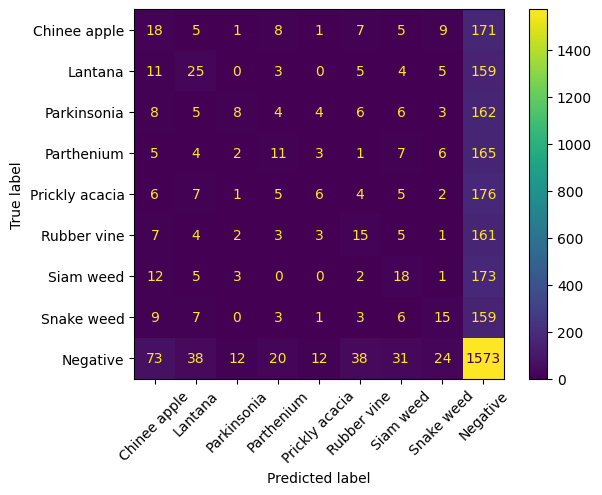

In [23]:
print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Freezing Base Model

In [24]:
with strategy.scope():
    for layer in model.layers:
        if 'base' in layer.name.lower():
            print("Freezing layer", layer.name, layer.trainable)
            layer.trainable = False

Freezing layer MobilenetV3small_base_ True


# Evaluations #1.1b

Test After Freezing
Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 23ms/step - loss: 0.0029 - accuracy: 0.9895
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99699   0.97929   0.98806       676
       Lantana    0.99529   0.99373   0.99451       638
   Parkinsonia    0.99357   0.99838   0.99597       619
    Parthenium    0.98080   1.00000   0.99031       613
Prickly acacia    0.99214   0.99058   0.99136       637
   Rubber vine    0.99835   0.99835   0.99835       606
     Siam weed    0.99226   0.99380   0.99303       645
    Snake weed    0.97903   0.99508   0.98699       610
      Negative    0.99670   0.99451   0.99560      5464

      accuracy                        0.99400     10508
     macro avg    0.99168   0.99375   0.99269     10508
  weighted avg    0.99404   0.99400   0.99401     10508


                False Positive Rate  Accuracy
Chinee apple               0.000203  0.979290
Lantana                    0.000304  0.993730
Parkinsonia                0.000404  0.998384
Parthenium                 0.001213  1.000000
Prickly acacia    

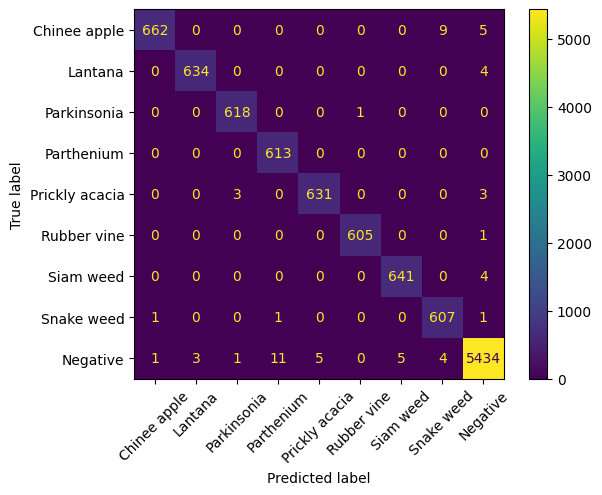

Validation Set Stats
model.evaluate
110/110 [==============================] - 3s 27ms/step - loss: 0.0195 - accuracy: 0.9435
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.92611   0.83556   0.87850       225
       Lantana    0.93953   0.94836   0.94393       213
   Parkinsonia    0.97608   0.99029   0.98313       206
    Parthenium    0.93088   0.98537   0.95735       205
Prickly acacia    0.93868   0.93427   0.93647       213
   Rubber vine    0.95980   0.94554   0.95262       202
     Siam weed    0.97129   0.94419   0.95755       215
    Snake weed    0.89655   0.89655   0.89655       203
      Negative    0.96678   0.97474   0.97074      1821

      accuracy                        0.95518      3503
     macro avg    0.94508   0.93943   0.94187      3503
  weighted avg    0.95505   0.95518   0.95489      3503


                False Positive Rate  Accuracy
Chinee apple               0.004576  0.835556
Lantana                    0.003951  0.948357
Parkinsonia                0.001517  0.990291
Parthenium                 0.004548  0.985366
Prickly acacia    

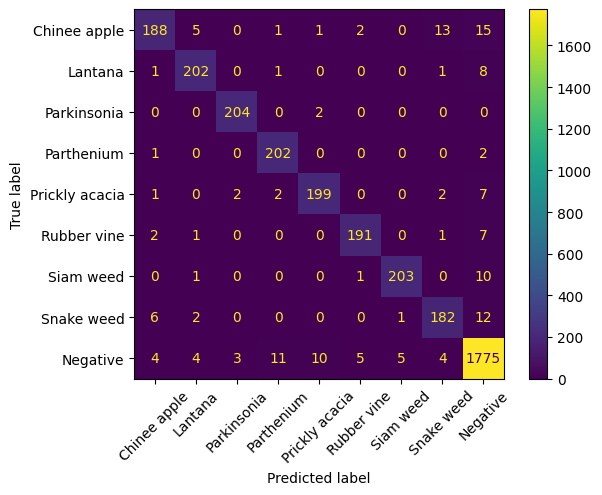

Test Set Stats
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.4935 - accuracy: 0.4828
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93299   0.80444   0.86396       225
       Lantana    0.94787   0.94340   0.94563       212
   Parkinsonia    0.95755   0.98544   0.97129       206
    Parthenium    0.95567   0.95098   0.95332       204
Prickly acacia    0.93396   0.93396   0.93396       212
   Rubber vine    0.95588   0.97015   0.96296       201
     Siam weed    0.95327   0.95327   0.95327       214
    Snake weed    0.89706   0.90148   0.89926       203
      Negative    0.96095   0.97309   0.96698      1821

      accuracy                        0.95197      3498
     macro avg    0.94391   0.93513   0.93896      3498
  weighted avg    0.95175   0.95197   0.95152      3498


                False Positive Rate  Accuracy
Chinee apple               0.003972  0.804444
Lantana                    0.003348  0.943396
Parkinsonia                0.002734  0.985437
Parthenium                 0.002732  0.950980
Prickly acacia    

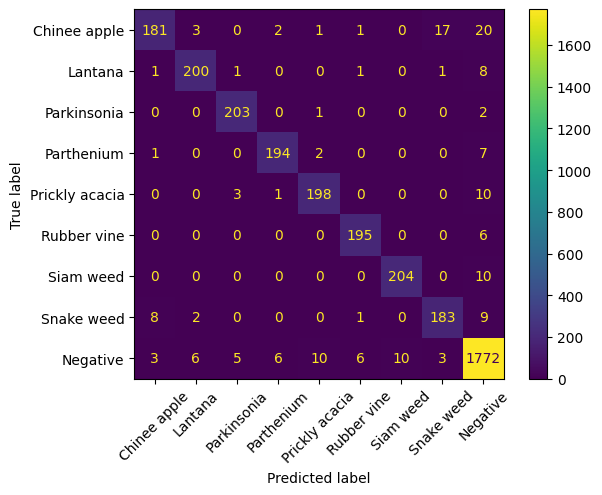

In [25]:
## Test After Freezing
print("Test After Freezing")

print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("Validation Set Stats")        
a, b = eval_model(model, validation_generator)

print("Test Set Stats")   
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.86301   0.84000   0.85135       225
       Lantana    0.82996   0.96698   0.89325       212
   Parkinsonia    0.95755   0.98544   0.97129       206
    Parthenium    0.95567   0.95098   0.95332       204
Prickly acacia    0.86920   0.97170   0.91759       212
   Rubber vine    0.95545   0.96020   0.95782       201
     Siam weed    0.93578   0.95327   0.94444       214
    Snake weed    0.89706   0.90148   0.89926       203
      Negative    0.97267   0.93795   0.95499      1821

      accuracy                        0.93911      3498
     macro avg    0.91515   0.94089   0.92703      3498
  weighted avg    0.94118   0.93911   0.93946      3498


                False Positive Rate  Accuracy
Chinee apple               0.009166  0.840000
Lantana                    0.012781  0.966981
Parkinsonia                0.002734  0.985437
Parthenium                 0.002732  0.950980
Prickly acacia    

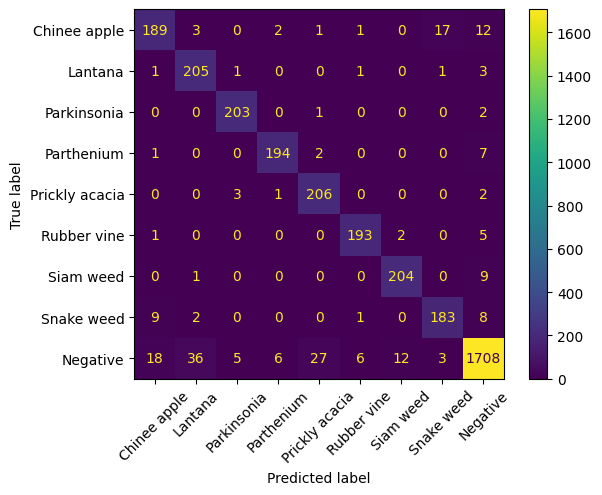

In [26]:
printStats(a,b,0.11)

# Trial 2

In [27]:
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=INIT_LR2,  weight_decay=W_DECAY2, clipnorm=2.0) if not USE_ADAMW else AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=ES_MONITOR, factor=LR_REDUCTION_FACTOR, patience=ES_PATIENCE, verbose=1, min_lr=MIN_LR2)


print(model.optimizer.get_config())

{'name': 'AdamW', 'weight_decay': 0.0005, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 2e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-07-06 08:50:39.570466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 17s 38ms/step - loss: 0.0202 - accuracy: 0.9320 - val_loss: 0.0154 - val_accuracy: 0.9552 - lr: 2.0000e-06
Epoch 2/300
329/329 [==============================] - 12s 36ms/step - loss: 0.0199 - accuracy: 0.9330 - val_loss: 0.0154 - val_accuracy: 0.9552 - lr: 2.0000e-06
Epoch 3/300
329/329 [==============================] - 12s 36ms/step - loss: 0.0195 - accuracy: 0.9323 - val_loss: 0.0153 - val_accuracy: 0.9543 - lr: 2.0000e-06
Epoch 4/300
329/329 [==============================] - 11s 34ms/step - loss: 0.0180 - accuracy: 0.9380 - val_loss: 0.0154 - val_accuracy: 0.9540 - lr: 2.0000e-06
Epoch 5/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0181 - accuracy: 0.9404 - val_loss: 0.0154 - val_accuracy: 0.9552 - lr: 2.0000e-06
Epoch 6/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0183 - accuracy: 0.9389 - val_loss: 0.0155 - val_accuracy: 0.9555 - lr: 2.0000e-06
Epoch 7/300
329/329 [===================

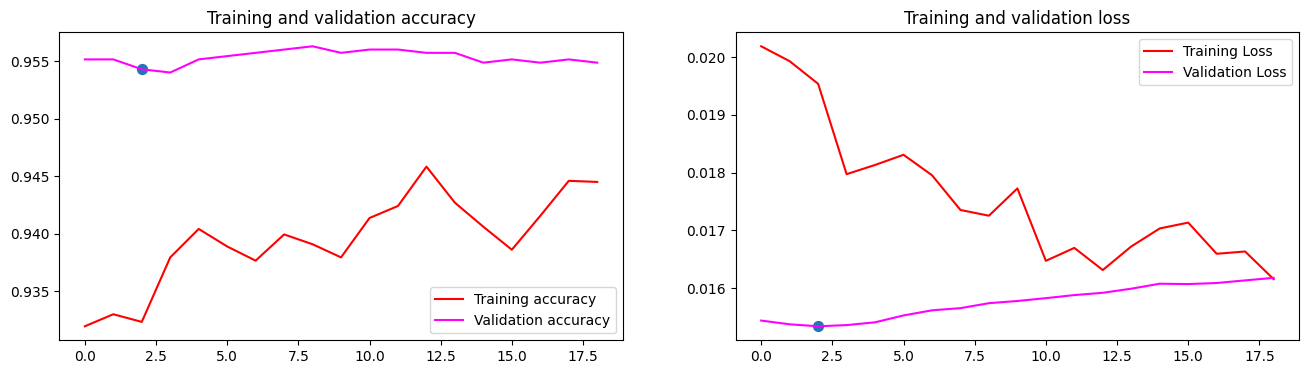

In [28]:
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Checkpoint")
model.save("2-"+MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)


# Accuracy / Loss Plots

Total Epochs: range(0, 109)


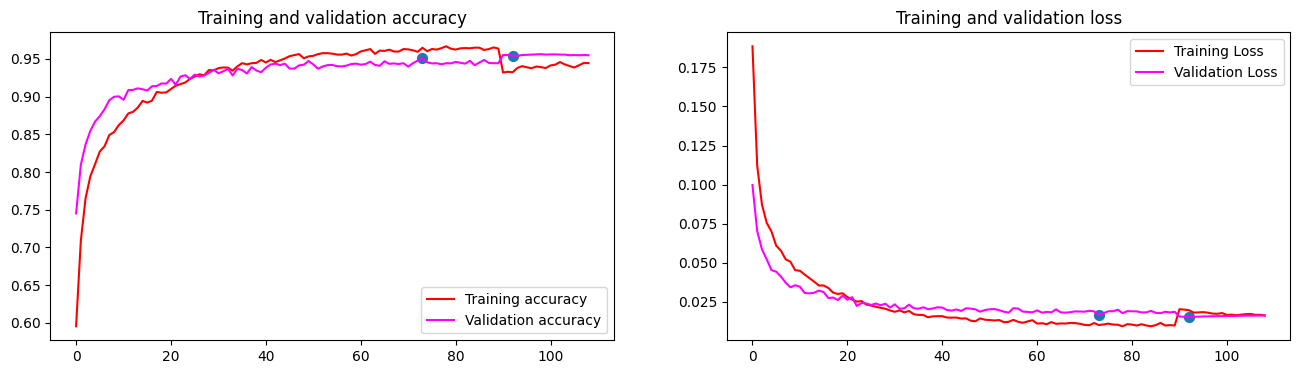

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 90)


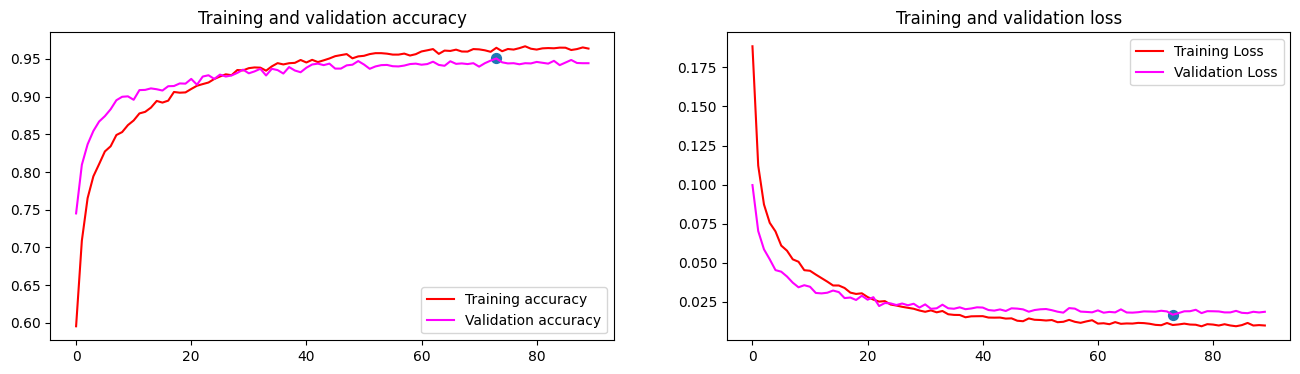

Total Epochs: range(0, 19)


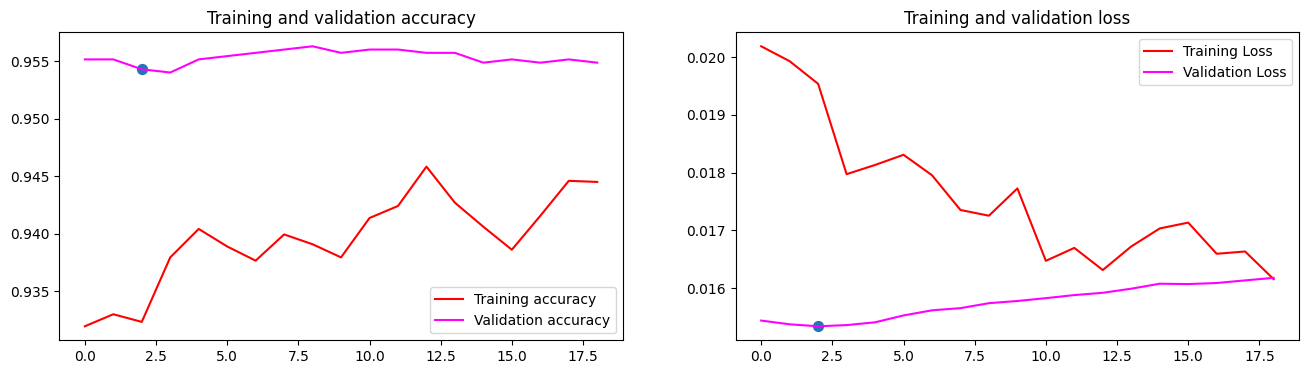

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 7s 22ms/step - loss: 0.0015 - accuracy: 0.9945
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99698   0.97633   0.98655       676
       Lantana    0.99528   0.99060   0.99293       638
   Parkinsonia    0.99677   0.99677   0.99677       619
    Parthenium    0.99031   1.00000   0.99513       613
Prickly acacia    0.99218   0.99529   0.99373       637
   Rubber vine    0.99507   0.99835   0.99671       606
     Siam weed    0.99230   0.99845   0.99536       645
    Snake weed    0.97125   0.99672   0.98382       610
      Negative    0.99743   0.99506   0.99624      5464

      accuracy                        0.99448     10508
     macro avg    0.99195   0.99417   0.99303     10508
  weighted avg    0.99453   0.99448   0.99448     10508


                False Positive Rate  Accuracy
Chinee apple               0.000203  0.976331
Lantana                    0.000304  0.990596
Parkinsonia                0.000202  0.996769
Parthenium                 0.000606  1.000000
Prickly acacia    

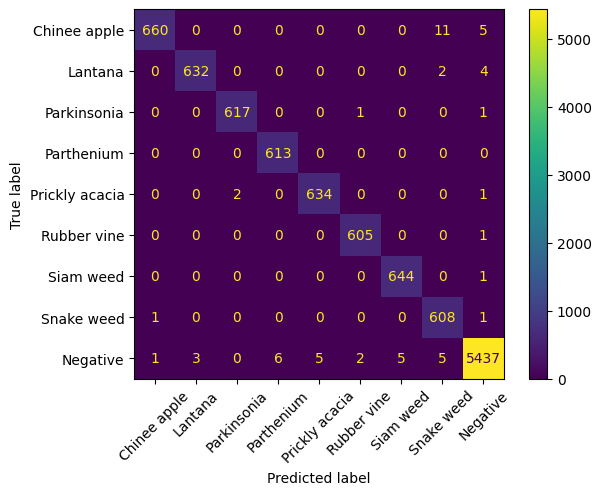


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 20ms/step - loss: 0.0153 - accuracy: 0.9543
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.92386   0.80889   0.86256       225
       Lantana    0.94340   0.93897   0.94118       213
   Parkinsonia    0.98068   0.98544   0.98305       206
    Parthenium    0.94836   0.98537   0.96651       205
Prickly acacia    0.92627   0.94366   0.93488       213
   Rubber vine    0.95500   0.94554   0.95025       202
     Siam weed    0.96262   0.95814   0.96037       215
    Snake weed    0.87143   0.90148   0.88620       203
      Negative    0.96836   0.97474   0.97154      1821

      accuracy                        0.95432      3503
     macro avg    0.94222   0.93802   0.93962      3503
  weighted avg    0.95424   0.95432   0.95399      3503


                False Positive Rate  Accuracy
Chinee apple               0.004576  0.808889
Lantana                    0.003647  0.938967
Parkinsonia                0.001213  0.985437
Parthenium                 0.003335  0.985366
Prickly acacia    

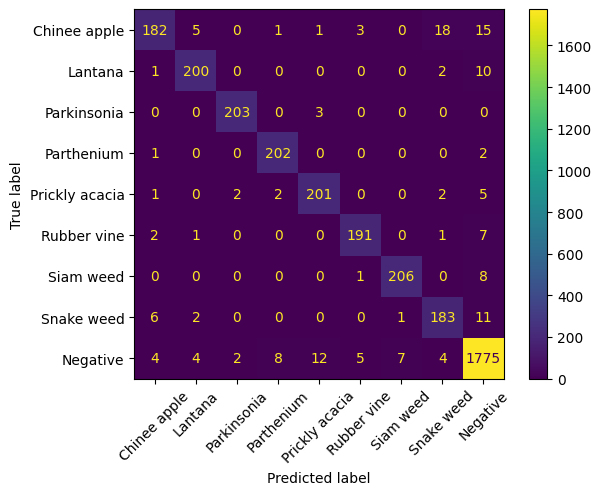


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0156 - accuracy: 0.9508
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93194   0.79111   0.85577       225
       Lantana    0.95238   0.94340   0.94787       212
   Parkinsonia    0.97129   0.98544   0.97831       206
    Parthenium    0.97000   0.95098   0.96040       204
Prickly acacia    0.93427   0.93868   0.93647       212
   Rubber vine    0.94203   0.97015   0.95588       201
     Siam weed    0.93213   0.96262   0.94713       214
    Snake weed    0.87619   0.90640   0.89104       203
      Negative    0.96189   0.97035   0.96610      1821

      accuracy                        0.95083      3498
     macro avg    0.94135   0.93546   0.93766      3498
  weighted avg    0.95081   0.95083   0.95039      3498


                False Positive Rate  Accuracy
Chinee apple               0.003972  0.791111
Lantana                    0.003043  0.943396
Parkinsonia                0.001823  0.985437
Parthenium                 0.001821  0.950980
Prickly acacia    

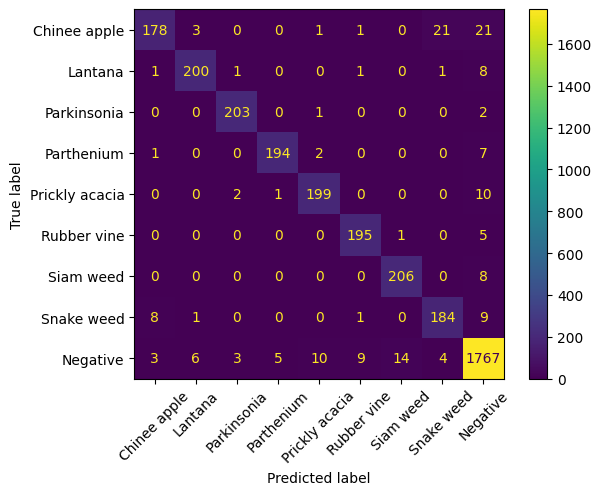

In [31]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85714   0.82667   0.84163       225
       Lantana    0.82000   0.96698   0.88745       212
   Parkinsonia    0.97129   0.98544   0.97831       206
    Parthenium    0.97000   0.95098   0.96040       204
Prickly acacia    0.86611   0.97642   0.91796       212
   Rubber vine    0.94175   0.96517   0.95332       201
     Siam weed    0.91964   0.96262   0.94064       214
    Snake weed    0.87619   0.90640   0.89104       203
      Negative    0.97418   0.93245   0.95286      1821

      accuracy                        0.93682      3498
     macro avg    0.91070   0.94146   0.92484      3498
  weighted avg    0.93946   0.93682   0.93726      3498


                False Positive Rate  Accuracy
Chinee apple               0.009471  0.826667
Lantana                    0.013694  0.966981
Parkinsonia                0.001823  0.985437
Parthenium                 0.001821  0.950980
Prickly acacia    

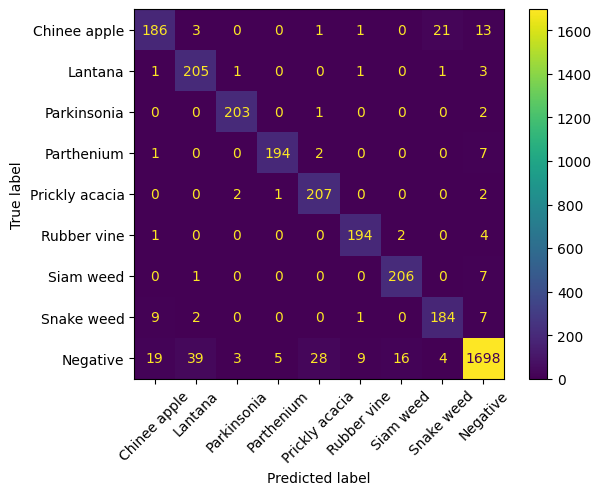

In [32]:
printStats(a,b,0.11)

## Clear Files

In [33]:
shutil.rmtree(base_dir)